<a href="https://colab.research.google.com/github/Pillangocska/Machine_Learning_VIMIMA05/blob/main/ML_lab1_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayesian classifiers

In this tutorial, we will use our knowledge of Bayesian inference to produce a simple multiclass classifier. More specifically, if we have an input $\mathbf x$ (e.g. lab measurements of a patient), we aim to construct a model which can predict a corresponding label $y$ (e.g. a diagnosis). In our investigations, we will use vectorial data (i.e. $\mathbf x \in \mathbb{R}^D$) and integer labels (i.e. $y \in \left\lbrace 1, 2, \ldots, K\right\rbrace$). Our strategy will be as follows:

1. We take some samples $\mathbf x_i$ with known labels $y_i$ (training set) and use these to tune the model parameters (which is called training the model),
2. We use the trained model to produce predictions on new samples $\mathbf x$ (test set).

## A Bayesian take on classification

The posterior probability of an input $\mathbf x$ belonging to the $k$ th class can be written using Bayes' rule as
\begin{align*}
p\left(y=k \;\mid\; \mathbf x\right) = \frac{p\left(\mathbf x \;\mid\; y=k\right)p\left(y=k\right)}{p\left(\mathbf x\right)} .
\end{align*}
We aim to find the most probable class for the input. Since the denominator is the same for all $k$, we can safely ignore it:
\begin{align*}
p\left(y=k \;\mid\; \mathbf x\right) \propto p\left(\mathbf x \;\mid\; y=k\right) p\left(y=k\right).
\end{align*}

Now we have to estimate the quantities on the right using the training set.
- $p\left(y=k\right)$ is easy as we can just use the ratio of samples belonging to class $k$ in the training set.
- $ p\left(\mathbf x \;\mid\; y=k\right)$ is somewhat more involved. Let as assume that the entries in a sample $\mathbf x$ are independent (a very naive assumption) and follow a Gaussian distribution. Formally, we assume that
\begin{align*}
p\left(\mathbf x \;\mid\; y=k\right) &= p\left(\mathbf x^1 \;\mid\; y=k\right) \cdot p\left(\mathbf x^2 \;\mid\; y=k\right) \cdots p\left(\mathbf x^D \;\mid\; y=k\right),\\
p\left(\mathbf x^l \;\mid\; y=k\right) &= \mathcal N \left(\mathbf x^l \;\mid\; \mu_k^l, {\sigma^2}_k^l \right),
\end{align*}
where $\mathbf x^l$ denotes the $l$ th component of $\mathbf x$. Now the only thing keeping us from making predictions is that we don't know $\mu_k^l$ and ${\sigma^2}_k^l$. However, they are easily estimated using the mean and variance of the $l$th component of the samples belonging to class $k$ in the training set.

This model is called Naive Bayes and despite its simplicity, it tends to perform fairly well on a large number of problems.

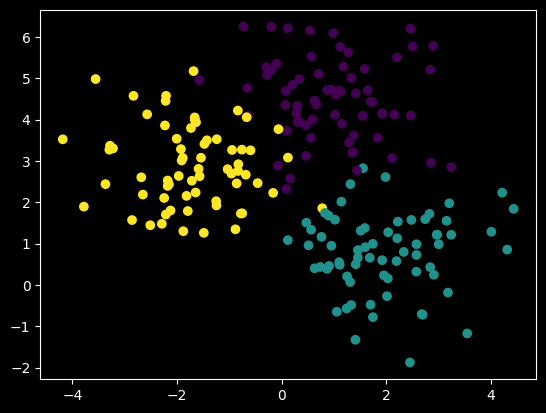

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs

N = 200 # number of training samples
K = 3   # number of classes
D = 2   # number of dimensions

np.random.seed(0)
X,y = make_blobs(n_samples=N,n_features=D,centers=K)
plt.style.use('dark_background')
plt.scatter(X[:,0],X[:,1],c=y)

## Inferring the model parameters

Now we have to compute the class probabilities $p(y=k)$ and the $\mu_k^l$, ${\sigma^2}_k^l$ parameters using the training set.

**Exercise 1.** Compute the prior $p(y=k)$ for all $k$. Store the values in a numpy array of length $K$, e.g. `array([0.2 0.5 0.3])`.

In [ ]:
# Compute p(y=k)
p_y_k = np.array([np.sum(y == k) / N for k in range(K)])

p_y_k

array([0.335, 0.335, 0.33 ])

**Exercise 2.** Compute $\mu_k^l$, ${\sigma^2}_k^l$ parameters using the training set. Store the values in numpy arrays of size $K \times D$.

In [ ]:
# Compute mu, sigma^2

# initialize arrays
mu = np.zeros((K, D))
sigma_squared = np.zeros((K, D))

for k in range(K):
    X_k = X[y == k]  # samples belonging to class k
    # we have 3 classes in X_k
    mu[k] = np.mean(X_k, axis=0)  # mean for each dimension
    # axis=0 -> in each row
    sigma_squared[k] = np.var(X_k, axis=0)  # variance for each dimension
    # variance = szorasnegyzet
    # standard deviation = szoras?

(mu, sigma_squared)


(array([[ 0.95519883,  4.48947436],
        [ 1.96384772,  0.76510874],
        [-1.72504914,  2.87780737]]),
 array([[0.96589198, 0.95975764],
        [0.99998999, 0.88877407],
        [0.92382865, 0.90085728]]))

In [ ]:
# like this too:
mu = [np.mean(X[y==0], axis=0) for i in range(3)]
mu = np.array(mu)
mu

array([[0.95519883, 4.48947436],
       [0.95519883, 4.48947436],
       [0.95519883, 4.48947436]])

Let us take a closer look at what we have achieved here. We inferred the parameters of the Gaussian distributions $p\left(\mathbf x^l \;\mid\; y=k\right)$, which we can visualize on the same plot as the training data. We do this using the `scipy` package, which can compute the probability density functions (pdfs) of the Gaussians for us.

First, let us generate some test data. We will use an evenly spaced grid on $[-5,5] \times [-2,7]$. Let us use $50$ samples in each dimension, i.e. this will yield a test set of size $50 \times 50 = 2500$.

In [ ]:
# Generate test data on a grid
l1,l2  = np.linspace(-5,5,50),np.linspace(-2,9,50)
g1,g2  = np.meshgrid(l1,l2)
X_test = np.vstack([g1.flatten(),g2.flatten()]).T
print(X_test)

[[-5.         -2.        ]
 [-4.79591837 -2.        ]
 [-4.59183673 -2.        ]
 ...
 [ 4.59183673  9.        ]
 [ 4.79591837  9.        ]
 [ 5.          9.        ]]


**Exercise 3.** Visualize the learned Gaussians via a contour plot. In more detail:

1. Make a scatter plot of the training data,
2. Use the `plt.contour()` and `multivariate_normal().pdf()` function to plot the Gaussians.

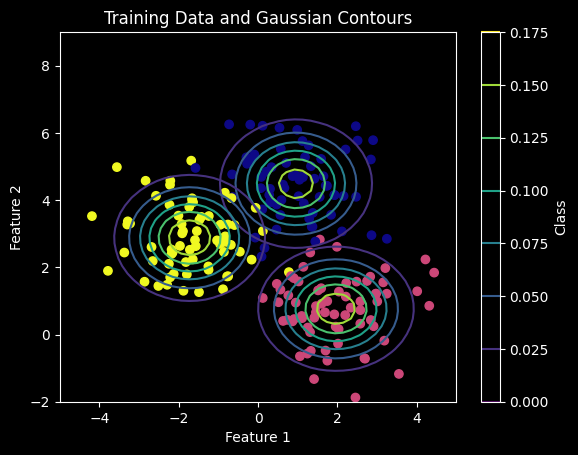

In [ ]:
from scipy.stats import multivariate_normal

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='plasma')

for k in range(K):
    rv = multivariate_normal(mean=mu[k], cov=np.diag(sigma_squared[k]))
    Z = rv.pdf(X_test).reshape(50, 50)
    plt.contour(g1, g2, Z)

plt.title("Training Data and Gaussian Contours")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Class") # certainty?
plt.show()

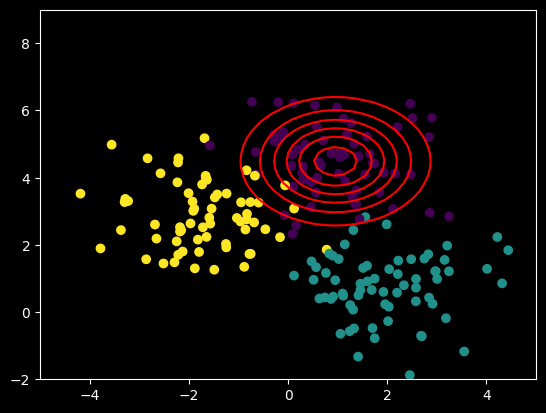

In [ ]:
#this way too:
plt.scatter(X[:,0],X[:,1],c=y)
plt.contour(l1,l2,multivariate_normal(mu[0],sigma_squared[0]).pdf(X_test).reshape(50,50),colors="red")

**Exercise 4.** How does the naive assumption affect the shape of these Gaussians? Write your short answer below.

**Answer:**  The shape of these Gaussians are restricted to ellipsoids, but they will always be parallel to the main axes.


## Making predictions

Recall that when making predictions on the test set, we have to compute the unnormalized posterior for each class:
\begin{align*}
p\left(y=k \;\mid\; \mathbf x\right) \propto p\left(\mathbf x \;\mid\; y=k\right) p\left(y=k\right).
\end{align*}
We have everything to make this happen from the previous steps. For an efficient implementation, we turn to the `scipy` library, which can compute this for all test samples in one go.

**Exercise 5.** Use the formula to compute the unnormalized posterior probability $p\left(y=k \;\mid\; \mathbf x\right)$ for each test sample and each class. Store the results in a $M \times K$ numpy array where $M$ is the number of test samples and $K$ is the number of classes.

In [ ]:
# Compute unnormalized posterior probabilities
M = X_test.shape[0]  # number of test samples
unnormalized_posterior = np.zeros((M, K)) # initial stuff

for k in range(K):
    # likelihood p(x|y=k)
    likelihood = multivariate_normal(mean=mu[k], cov=np.diag(sigma_squared[k])).pdf(X_test)

    # unnormalized posterior p(y=k|x) = p(x|y=k) * p(y=k)
    unnormalized_posterior[:, k] = likelihood * p_y_k[k]

unnormalized_posterior


array([[1.74648001e-19, 2.25801798e-14, 3.19172299e-10],
       [6.01529803e-19, 9.16022005e-14, 6.43327539e-10],
       [1.98437560e-18, 3.56447990e-13, 1.23953739e-09],
       ...,
       [1.46907334e-09, 4.83547268e-20, 2.21958650e-20],
       [6.66772019e-10, 2.76993641e-20, 5.37581572e-21],
       [2.89857442e-10, 1.52199217e-20, 1.24462125e-21]])

In [ ]:
unnormalized_posterior.size

7500

In [ ]:
print(unnormalized_posterior[0])

[1.74648001e-19 2.25801798e-14 3.19172299e-10]


In [ ]:
print(unnormalized_posterior[1])

[6.01529803e-19 9.16022005e-14 6.43327539e-10]


**Exercise 6.** Compute predictions by taking the most probable class for each test sample.

In [ ]:
# just picking the biggest one and thats the class corresponding to that position
predictions = np.argmax(unnormalized_posterior, axis=1)

print(predictions)
predictions.size

[2 2 2 ... 0 0 0]


2500

**Exercise 7.** Visualize the decision boundaries via using a contour plot. In more detail:

- Make a scatter plot of the training data,
- Resize your predictions to a $50\times 50$ array and make a contour plot.

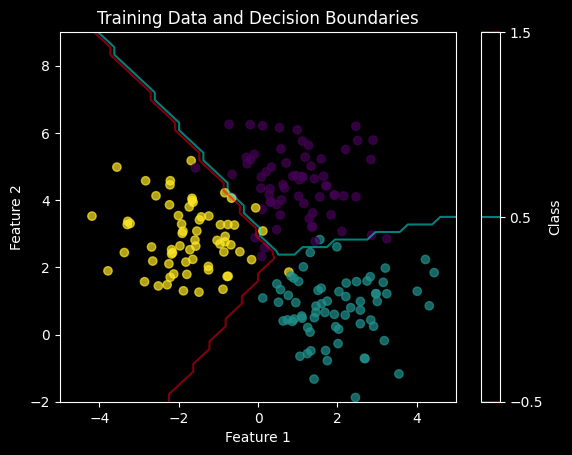

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7)

# resize predictions to a 50x50 array for contour plot
predictions_reshaped = predictions.reshape(50, 50)

# decision boundaries
plt.contour(g1, g2, predictions_reshaped, levels=np.arange(K)-0.5, cmap='hsv', alpha=0.5)

plt.title("Training Data and Decision Boundaries")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Class")
plt.show()


## Naive Bayes using an external package

We can also do Naive Bayes using the `scikit-learn` package. This is straightforward to implement:

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Gaussian Naive Bayes classifier
nb = GaussianNB()

# Inference
nb.fit(X,y)

# Prediction
pred_sklearn = nb.predict(X_test)

For a real-world application, let us demonstrate Naive Bayes on the `wine` dataset, which contains various chemical measurements of wines from the same region in Italy but three different cultivars (which we are to predict). First, let us take a look at the data.

In [ ]:
from sklearn.datasets import load_wine

load_wine(as_frame=True).data.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


We see that now we have $13$ dimensions. In this notebook, we won't care about careful data exploration and cleaning; let us just load the data into arrays, split them into training/test sets and see how well a Naive Bayesian classifier does.

In [ ]:
from sklearn.model_selection import train_test_split

# Load the data and split it
data = load_wine()
x,y  = data.data, data.target
x_train,x_test,y_train,y_test = train_test_split(x,y)

**Exercise 8.** Fit a Naive Bayesian classifier on the train data and evaluate its accuracy on the test data.

In [ ]:
from sklearn.metrics import accuracy_score

#nb_wine = GaussianNB()

nb.fit(x_train, y_train)

# predict on the test data
pred_wine = nb.predict(x_test)

# evaluate accuracy
accuracy_wine = accuracy_score(y_test, pred_wine)
accuracy_wine

0.9333333333333333

In [1]:
print("Done")

Done
